In [11]:
# Imported Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import roc_curve, roc_auc_score

# Other Libraries
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [13]:
scaled_train_df = pd.read_csv('Resources/scaled_train_data.csv')

In [15]:
scaled_train_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.788346,-1.623936
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269786,-1.623936
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.996638,-1.623910
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.422468,-1.623910
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.672923,-1.623883


In [18]:
# Get the number of rows for the class
class_distribution = scaled_train_df['Class'].value_counts()
class_percentages = scaled_train_df['Class'].value_counts(normalize=True) * 100

# Combine into a DataFrame for a clearer display
class_summary = pd.DataFrame({'Count': class_distribution, 'Percentage': class_percentages})

# Format the Count and Percentage columns
class_summary['Count'] = class_summary['Count'].apply(lambda x: f"{x:,.3f}")
class_summary['Percentage'] = class_summary['Percentage'].apply(lambda x: f"{x:,.3f}   %")

print(class_summary)

             Count  Percentage
Class                         
0      171,730.000  99.791   %
1          360.000   0.209   %


In [21]:
# Assuming scaled_train_df is already defined
X = scaled_train_df.drop('Class', axis=1)
y = scaled_train_df['Class']

# Define SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy='minority')
under_sampler = RandomUnderSampler(sampling_strategy='majority')

# Create a pipeline
pipeline = Pipeline(steps=[('smote', smote), ('under', under_sampler)])

# Apply the pipeline to the data
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Combine resampled data into a DataFrame
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['Class'] = y_resampled

# Display the new class distribution
class_distribution = resampled_df['Class'].value_counts()
class_percentages = resampled_df['Class'].value_counts(normalize=True) * 100

# Combine into a DataFrame for a clearer display
class_summary = pd.DataFrame({'Count': class_distribution, 'Percentage': class_percentages})

# Format the Count and Percentage columns
class_summary['Count'] = class_summary['Count'].apply(lambda x: f"{x:,.3f}")
class_summary['Percentage'] = class_summary['Percentage'].apply(lambda x: f"{x:,.3f}   %")

print(class_summary)

             Count  Percentage
Class                         
0      171,730.000  50.000   %
1      171,730.000  50.000   %


In [30]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost Model with the SMOTEENN

In [38]:
# Assuming scaled_train_df is already defined
X = scaled_train_df.drop('Class', axis=1)
y = scaled_train_df['Class']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTEENN to balance the dataset
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=10)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate the model
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
report_xgb = classification_report(y_val, y_pred_xgb)

print(f'Accuracy: {accuracy_xgb}')
print(f'Classification Report:\n{report_xgb}')


Accuracy: 0.9987797082921727
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34352
           1       0.64      0.85      0.73        66

    accuracy                           1.00     34418
   macro avg       0.82      0.92      0.86     34418
weighted avg       1.00      1.00      1.00     34418



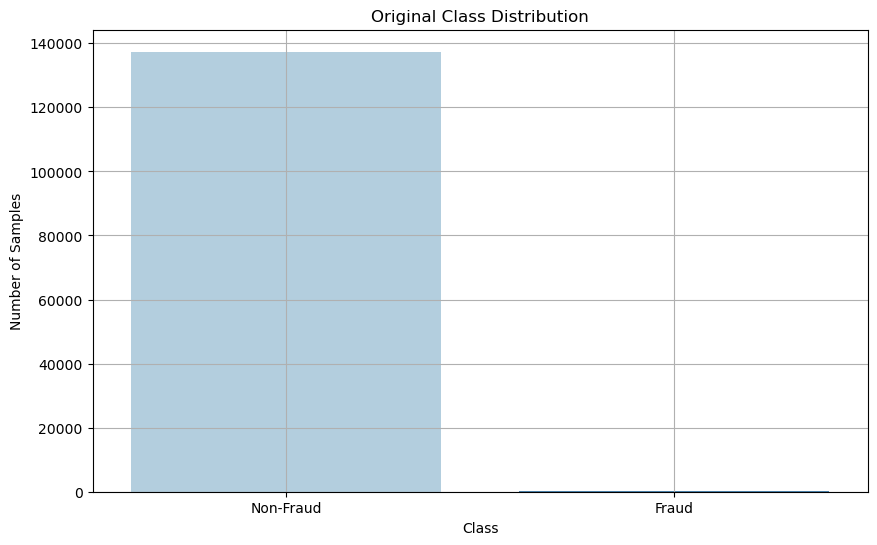

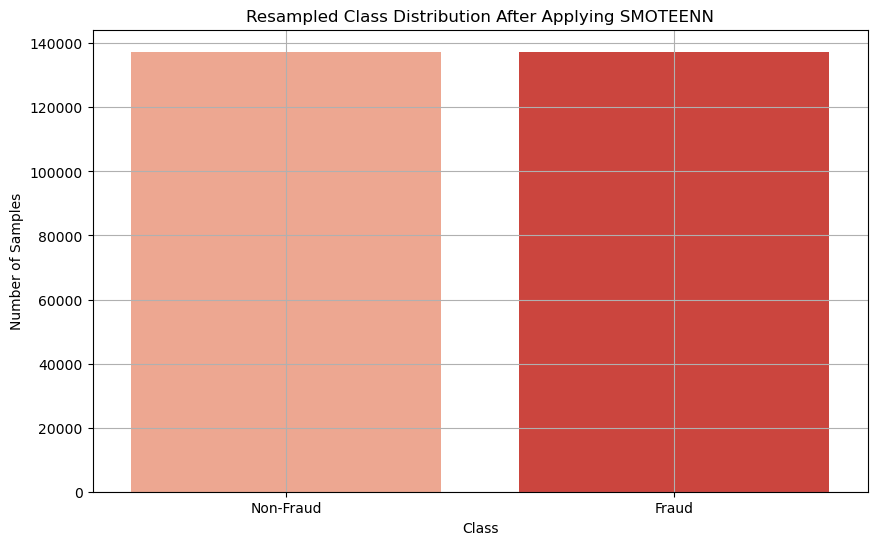

In [46]:
# Original class distribution
class_counts_original = y_train.value_counts()

# Resampled class distribution
class_counts_resampled = y_train_resampled.value_counts()

# Create a DataFrame for visualization
class_distribution_original_df = pd.DataFrame({
    'Class': ['Non-Fraud', 'Fraud'],
    'Count': class_counts_original.values
})

class_distribution_resampled_df = pd.DataFrame({
    'Class': ['Non-Fraud', 'Fraud'],
    'Count': class_counts_resampled.values
})

# Plot the original class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_distribution_original_df, palette='Blues')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Original Class Distribution')
plt.grid(True)
plt.savefig('output/original_class_distribution.png', format='png')
plt.show()

# Plot the resampled class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_distribution_resampled_df, palette='Reds')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Resampled Class Distribution After Applying SMOTEENN')
plt.grid(True)
plt.savefig('output/resampled_class_distribution_smoteenn.png', format='png')
plt.show()


In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 10, 25],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

# Evaluate the best model
y_pred_best_xgb = best_xgb_model.predict(X_val)
accuracy_best_xgb = accuracy_score(y_val, y_pred_best_xgb)
report_best_xgb = classification_report(y_val, y_pred_best_xgb)

print(f'Accuracy: {accuracy_best_xgb}')
print(f'Classification Report:\n{report_best_xgb}')


### XGBoost model achieved a high level of accuracy and a significant improvement in precision for fraud detection.

- **Overall Accuracy: 0.9993026**
- **Precision for Fraud (Class 1): 0.8**
- **Recall for Fraud (Class 1): 0.85**
- **f1-Score (Class 1): 0.82**
  
With these impressive metrics, the XGBoost model proves to be highly effective in catching fraud cases while maintaining a minimal rate of false positives. This ensures enhanced security and reliability in fraud detection.

In [ ]:
# Train the XGBoost model again if needed
xgb_model.fit(X_train_resampled, y_train_resampled)

# Get feature importances
importances = xgb_model.feature_importances_

# Print or plot the feature importances
for feature, importance in zip(X_train.columns, importances):
    print(f"Feature: {feature}, Importance: {importance}")

# Optionally, plot the feature importances for a visual aid
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [X_train.columns[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Descending)')
plt.gca().invert_yaxis()
plt.savefig('output/feature_importances.png', format='png')
plt.show()

In [ ]:
import pickle
# Save the model to a file
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)

In [ ]:
# Later use X_test 
# Load the model from the file
with open('best_xgb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
# Use the loaded model to make predictions
predictions = loaded_model.predict(X_train)

In [ ]:
scaled_test_df = pd.read_csv('../Resources/scaled_test_data.csv')

In [ ]:
# Drop the Class for the scaled_test data 
X_test = scaled_test_df.drop('Class', axis=1)
y_test = scaled_test_df['Class']

In [ ]:
# Later use X_test 
# Load the model from the file
with open('best_xgb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
# Use the loaded model to make predictions
predictions = loaded_model.predict(X_test)

In [ ]:
ssr = ((predictions - y_test)**2).sum()
ssr

In [ ]:
# Production with the best model
with open('best_xgb_model.pkl', 'rb') as file:
    loaded_xgb_model = pickle.load(file)
y_pred = loaded_xgb_model.predict(X_test)
accuracy_production_xgb = accuracy_score(y_test, y_pred)
report_production_xgb = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy_production_xgb}')
print(f'Classification Report:\n{report_production_xgb}')

In [ ]:
# Save the accuracy and classification report to a text file
with open('output/production_xgb_model_evaluation.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy_production_xgb}\n') 
    f.write(f'Classification Report:\n{report_production_xgb}\n')

In [ ]:
# Get predicted probabilities
y_prob = loaded_xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('../output/roc_curve.png', format='png')
plt.show()
